# Effects Of Inflation on Stock Market

In [1]:
import pyspark
import nltk
import warnings
import csv
import re
import datetime
import re
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql import Row
from pyspark.sql import functions as F

from pyspark.sql.window import Window
from pyspark.sql.types import *
# from pyspark.sql.functions import *
from pyspark.sql.functions import round as Round
from pyspark.sql.functions import concat_ws as concat
from pyspark.sql.functions import udf, year, month, date_format
from pyspark.sql.functions import monotonically_increasing_id,row_number
from pyspark.sql.functions import col, unix_timestamp, to_date, lit, regexp_replace, lower, format_number

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from asyncio.windows_events import NULL
from gc import collect
from numpy import empty, row_stack
warnings.filterwarnings('ignore')

In [2]:
# Creating a spark session

spark = SparkSession.builder.appName('DM').config("spark.executor.heartbeatInterval", "110000ms ").getOrCreate() 

In [3]:
# Creating path variables for all available data

data_path = "" # Path to Data folder
lexicon_path = "" # Path to lexicon data for sentiment analysis
news_path = data_path + "" # Path to news data
external_data = data_path + "\external_factors"
main_data_path = data_path + "\DJUSCG.csv" # Path to DJUSCG index data
fin_data_path = data_path + "\\final_data.csv"

gdp_df = spark.read.csv(external_data+"\gdp.csv", header=True, inferSchema=True)
inflation_df = spark.read.csv(external_data+"\inflation.csv", header=True, inferSchema=True)
unemp_df = spark.read.csv(external_data+"\\unemp.csv", header=True, inferSchema=True)

In [4]:
# Loading DJUSCG price data into data_frame as spark dataframe

data_frame = spark.read.format('csv').option('header','true').load(main_data_path)

# TODAY AND TOMORROW TREND

In [5]:
data_frame.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Chg: string (nullable = true)



In [6]:
# Converting attribute Date from type String to type Timestamp

data_frame = data_frame.withColumn('Date', to_date(unix_timestamp(col('Date'), 'dd-MM-yyyy').cast("timestamp")))

In [7]:
# Adding attribute Tommorrow Close to data which is the cost of the following day

data_frame = data_frame.withColumn(
    "Tomorrow_Close",
    functions.lead("Price",1).over(Window.orderBy(monotonically_increasing_id())))

In [8]:
# Adding attribute Today Trend to data based on the Opening and Closing price of the particular day

data_frame =data_frame.withColumn(
    "Today_Trend",
    functions.when(functions.col('Open')<functions.col('Price'),"UP").otherwise("DOWN"))

In [9]:
# Adding attribute Tomorrow Trend based on the Closing of current day and Closing of next day

data_frame = data_frame.withColumn(
    "Tomorrow_Trend",
    functions.when(functions.lead("Price",1).over(Window.orderBy(monotonically_increasing_id())) <   functions.col('Price'),
                   "DOWN").otherwise("UP"))

In [10]:
# Creating an instance of the data frame as a table on which sql queries are run

data_frame.createOrReplaceTempView('sql_data_frame')

# Selecting attributes from the table only between dates 01/02/205 to 03/31/2020

data_frame = spark.sql("SELECT * FROM sql_data_frame WHERE Date between '2015-01-02' and '2020-03-31'")

In [11]:
# Printing 10 records of the data frame with the newly added attributes

data_frame.show(10)

+----------+------+------+------+------+-------+-------+--------------+-----------+--------------+
|      Date| Price|  Open|  High|   Low| Volume|    Chg|Tomorrow_Close|Today_Trend|Tomorrow_Trend|
+----------+------+------+------+------+-------+-------+--------------+-----------+--------------+
|2020-03-31| 545.7| 554.2|557.82|543.75|628.15M|-0.0187|        556.11|       DOWN|            UP|
|2020-03-30|556.11|544.04|557.98|543.28|454.73M| 0.0324|        538.64|         UP|          DOWN|
|2020-03-27|538.64|535.44|553.94|530.38|481.76M|-0.0148|        546.74|         UP|            UP|
|2020-03-26|546.74|523.51|549.11|523.07|594.86M| 0.0574|        517.05|         UP|          DOWN|
|2020-03-25|517.05|511.78| 533.4|506.02|725.00M| 0.0196|        507.13|         UP|          DOWN|
|2020-03-24|507.13|491.69|508.32|490.56|657.51M| 0.0798|        469.67|         UP|          DOWN|
|2020-03-23|469.67|480.21|486.55|460.48|668.08M| -0.029|        483.69|       DOWN|            UP|
|2020-03-2

# MARKET INDICATORS

SMI, RSI and K%

In [12]:
# converting Date column to a list

dateList = data_frame.select('Date').rdd.flatMap(lambda x: x).collect() 

SMA - Simple Moving Average

It is the average price over a specified period of time. It signals the general trend of the stock/index. If the price action is below the moving average the stock is in downtrend, if it stays above the moving average it signals uptrend.


In [13]:
# printing schema of dataframe to check data types

data_frame.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Price: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Chg: string (nullable = true)
 |-- Tomorrow_Close: string (nullable = true)
 |-- Today_Trend: string (nullable = false)
 |-- Tomorrow_Trend: string (nullable = false)



In [14]:
priceL=data_frame.select('price').rdd.flatMap(lambda x: x).collect() #converting price column to price list
SMA=[] #empty list for SMA
val=0
for i,j in enumerate(priceL):
    if(i>=7 and i<len(priceL)-7):
        for j in range(i-6,i+8):
            val+=float(priceL[j])
        val/=14
        SMA.append(round(val,2))

    else:
        if (i==0):
            val = round(((float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/9),2)
            SMA.append(val)

        if(i==1):
            val = round(((float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/10),2)
            SMA.append(val)

        if(i==2):
            val = round(((float(priceL[i-2])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/11),2)
            SMA.append(val)
   
        if(i==3):
            val = round(((float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/12),2)
            SMA.append(val)
       
        if(i==4):
            val = round(((float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/13),2)
            SMA.append(val)

        if(i==5):
            val = round(((float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/14),2)
            SMA.append(val)
   
        if(i==6):
            val = round(((float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/14),2)
            SMA.append(val)
   
        if(i==len(priceL)-7):
            val = round(((float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/14),2)
            SMA.append(val)

        if(i==len(priceL)-6):
            val = round(((float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5]))/13),2)
            SMA.append(val)

        if(i==len(priceL)-5):
            val = round(((float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4]))/12),2)
            SMA.append(val)

        if(i==len(priceL)-4):
            val = round(((float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3]))/11),2)
            SMA.append(val)

        if(i==len(priceL)-3):
            val = round(((float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2]))/10),2)
            SMA.append(val)

        if(i==len(priceL)-2):
            val = round(((float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1]))/9),2)
            SMA.append(val)

        if(i==len(priceL)-1):
            val = round(((float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i]))/8),2)
            SMA.append(val)

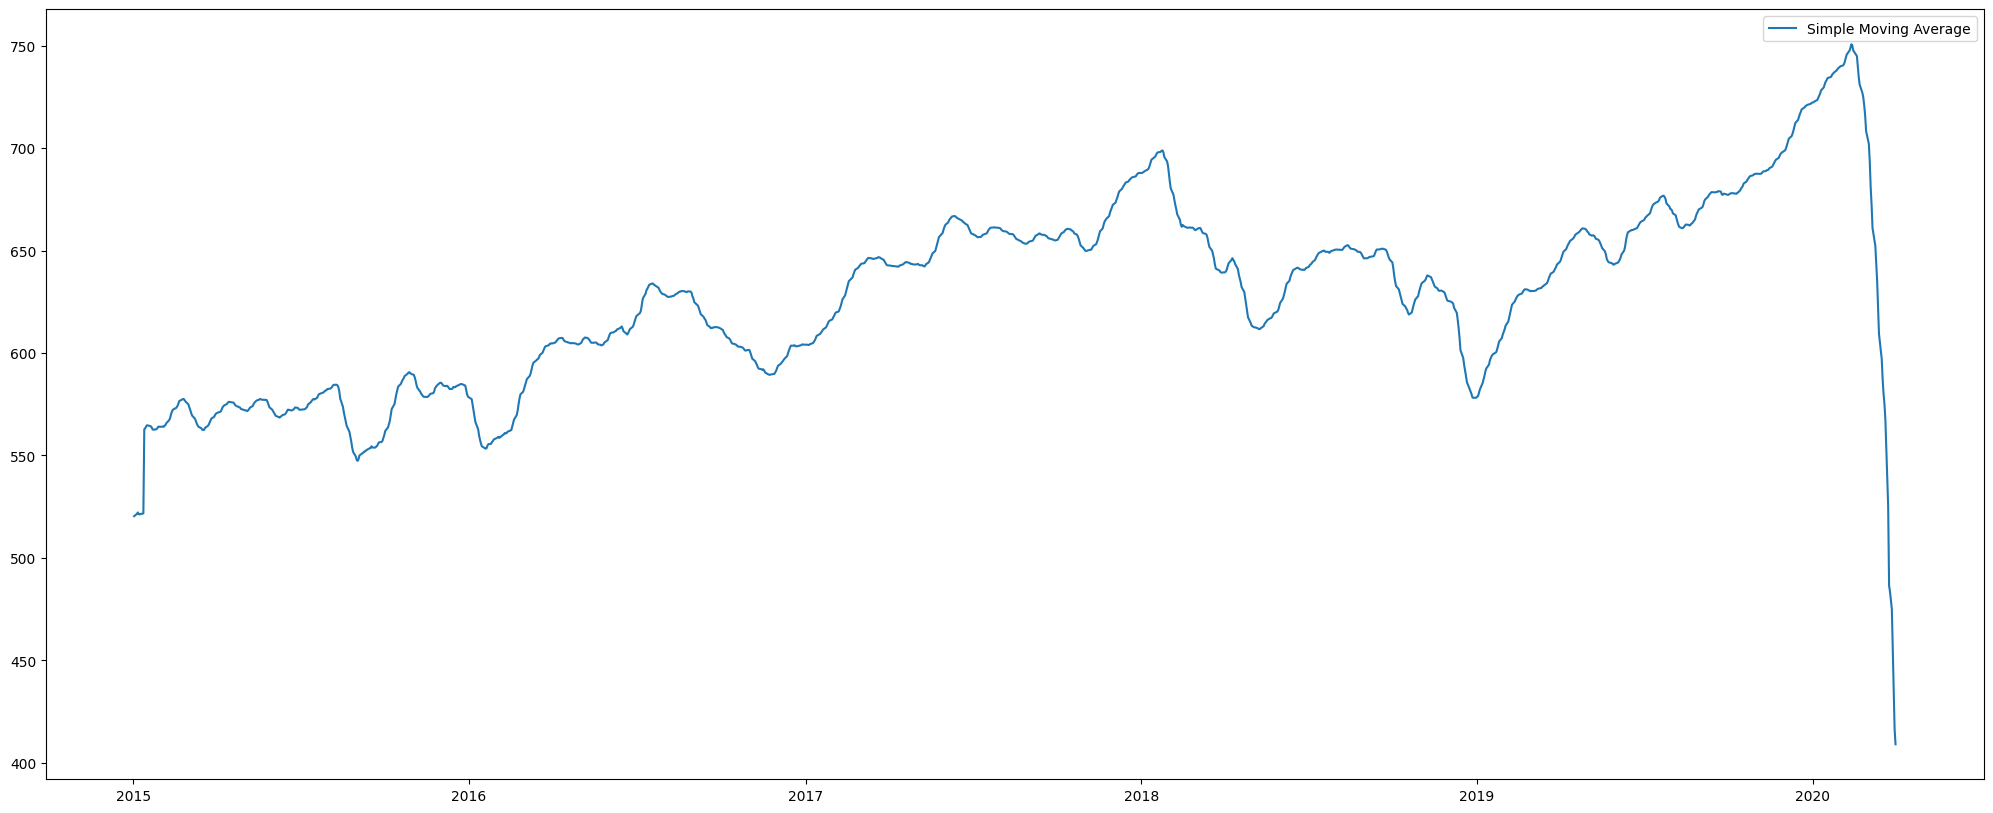

In [15]:
# Creating a figure of size 25x10
plt.figure(figsize = (25,10))

# Plotting Simple Moving Average vs the corresponding Date
plt.plot(dateList, SMA, label = 'Simple Moving Average')

plt.legend()
plt.show()

Stochastic Oscillator - K%

The stochastic oscillator is a momentum indicator that is widely used in forex trading to pinpoint potential trend reversals. This indicator measures momentum by comparing closing price to the trading range over a given period.

In [16]:
kp=[] # Stochastic Oscillator

# converting column low to a list
low =data_frame.select('Low').rdd.flatMap(lambda x: x).collect()

# converting column high to a list
high=data_frame.select('High').rdd.flatMap(lambda x: x).collect() 

low14=0
high14=0
for i,j in enumerate(priceL):
    if(i>=7 and i<len(priceL)-7):
        for j in range(i-6,i+8):
            low14=min(low14,float(low[j]))
            high14 = max(high14,float(high[j]))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
        kp.append(val)
    else:
        if (i==0):
            low14=min(((float(low[i]),float(low[i+1]),float(low[i+2]),float(low[i+3]),float(low[i+4]),float(low[i+5]),float(low[i+6]))))
            high14=max(((float(high[i]),float(high[i+1]),float(high[i+2]),float(high[i+3]),float(high[i+4]),float(high[i+5]),float(high[i+6]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)
           
        if(i==1):
            low14=min(((float(low[i-1]),float(low[i]),float(low[i+1]),float(low[i+2]),float(low[i+3]),float(low[i+4]),float(low[i+5]),float(low[i+6]))))
            high14=max(((float(high[i-1]),float(high[i]),float(high[i+1]),float(high[i+2]),float(high[i+3]),float(high[i+4]),float(high[i+5]),float(high[i+6]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)
            
        if(i==2):
            low14=min(((float(low[i-2]),float(low[i-1]),float(low[i]),float(low[i+1]),float(low[i+2]),float(low[i+3]),float(low[i+4]),float(low[i+5]),float(low[i+6]))))
            high14=max(((float(high[i-2]),float(high[i-1]),float(high[i]),float(high[i+1]),float(high[i+2]),float(high[i+3]),float(high[i+4]),float(high[i+5]),float(high[i+6]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)
            
        if(i==3):
            low14=min(((float(low[i-3]),float(low[i-2]),float(low[i-2]),float(low[i-1]),float(low[i]),float(low[i+1]),float(low[i+2]),float(low[i+3]),float(low[i+4]),float(low[i+5]),float(low[i+6]))))
            high14=max(((float(high[i-3]),float(high[i-2]),float(high[i-2]),float(high[i-1]),float(high[i]),float(high[i+1]),float(high[i+2]),float(high[i+3]),float(high[i+4]),float(high[i+5]),float(high[i+6]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)
            
        if(i==4):
            low14=min(((float(low[i-4]),float(low[i-3]),float(low[i-2]),float(low[i-2]),float(low[i-1]),float(low[i]),float(low[i+1]),float(low[i+2]),float(low[i+3]),float(low[i+4]),float(low[i+5]),float(low[i+6]))))
            high14=max(((float(high[i-4]),float(high[i-3]),float(high[i-2]),float(high[i-2]),float(high[i-1]),float(high[i]),float(high[i+1]),float(high[i+2]),float(high[i+3]),float(high[i+4]),float(high[i+5]),float(high[i+6]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)
             
        if(i==5):
            low14=min(((float(low[i-5]),float(low[i-4]),float(low[i-3]),float(low[i-2]),float(low[i-2]),float(low[i-1]),float(low[i]),float(low[i+1]),float(low[i+2]),float(low[i+3]),float(low[i+4]),float(low[i+5]),float(low[i+6]))))
            high14=max(((float(high[i-5]),float(high[i-4]),float(high[i-3]),float(high[i-2]),float(high[i-2]),float(high[i-1]),float(high[i]),float(high[i+1]),float(high[i+2]),float(high[i+3]),float(high[i+4]),float(high[i+5]),float(high[i+6]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)
        
        if(i==6):
            low14=min(((float(low[i-6]),float(low[i-5]),float(low[i-4]),float(low[i-3]),float(low[i-2]),float(low[i-2]),float(low[i-1]),float(low[i]),float(low[i+1]),float(low[i+2]),float(low[i+3]),float(low[i+4]),float(low[i+5]),float(low[i+6]))))
            high14=max(((float(high[i-6]),float(high[i-5]),float(high[i-4]),float(high[i-3]),float(high[i-2]),float(high[i-2]),float(high[i-1]),float(high[i]),float(high[i+1]),float(high[i+2]),float(high[i+3]),float(high[i+4]),float(high[i+5]),float(high[i+6]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)
            
        if(i==len(priceL)-7):
            low14=min(((float(low[i-6]),float(low[i-5]),float(low[i-4]),float(low[i-3]),float(low[i-2]),float(low[i-2]),float(low[i-1]),float(low[i]),float(low[i+1]),float(low[i+2]),float(low[i+3]),float(low[i+4]),float(low[i+5]),float(low[i+6]))))
            high14=max(((float(high[i-6]),float(high[i-5]),float(high[i-4]),float(high[i-3]),float(high[i-2]),float(high[i-2]),float(high[i-1]),float(high[i]),float(high[i+1]),float(high[i+2]),float(high[i+3]),float(high[i+4]),float(high[i+5]),float(high[i+6]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)
            
        if(i==len(priceL)-6):
            low14=min(((float(low[i-6]),float(low[i-5]),float(low[i-4]),float(low[i-3]),float(low[i-2]),float(low[i-2]),float(low[i-1]),float(low[i]),float(low[i+1]),float(low[i+2]),float(low[i+3]),float(low[i+4]),float(low[i+5]))))
            high14=max(((float(high[i-6]),float(high[i-5]),float(high[i-4]),float(high[i-3]),float(high[i-2]),float(high[i-2]),float(high[i-1]),float(high[i]),float(high[i+1]),float(high[i+2]),float(high[i+3]),float(high[i+4]),float(high[i+5]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)
        if(i==len(priceL)-5):
            low14=min(((float(low[i-6]),float(low[i-5]),float(low[i-4]),float(low[i-3]),float(low[i-2]),float(low[i-2]),float(low[i-1]),float(low[i]),float(low[i+1]),float(low[i+2]),float(low[i+3]),float(low[i+4]))))
            high14=max(((float(high[i-6]),float(high[i-5]),float(high[i-4]),float(high[i-3]),float(high[i-2]),float(high[i-2]),float(high[i-1]),float(high[i]),float(high[i+1]),float(high[i+2]),float(high[i+3]),float(high[i+4]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)
            
        if(i==len(priceL)-4):
            low14=min(((float(low[i-6]),float(low[i-5]),float(low[i-4]),float(low[i-3]),float(low[i-2]),float(low[i-2]),float(low[i-1]),float(low[i]),float(low[i+1]),float(low[i+2]),float(low[i+3]))))
            high14=max(((float(high[i-6]),float(high[i-5]),float(high[i-4]),float(high[i-3]),float(high[i-2]),float(high[i-2]),float(high[i-1]),float(high[i]),float(high[i+1]),float(high[i+2]),float(high[i+3]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)
            
        if(i==len(priceL)-3):
            low14=min(((float(low[i-6]),float(low[i-5]),float(low[i-4]),float(low[i-3]),float(low[i-2]),float(low[i-2]),float(low[i-1]),float(low[i]),float(low[i+1]),float(low[i+2]))))
            high14=max(((float(high[i-6]),float(high[i-5]),float(high[i-4]),float(high[i-3]),float(high[i-2]),float(high[i-2]),float(high[i-1]),float(high[i]),float(high[i+1]),float(high[i+2]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)
            
        if(i==len(priceL)-2):
            low14=min(((float(low[i-6]),float(low[i-5]),float(low[i-4]),float(low[i-3]),float(low[i-2]),float(low[i-2]),float(low[i-1]),float(low[i]),float(low[i+1]))))
            high14=max(((float(high[i-6]),float(high[i-5]),float(high[i-4]),float(high[i-3]),float(high[i-2]),float(high[i-2]),float(high[i-1]),float(high[i]),float(high[i+1]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)
            
        if(i==len(priceL)-1):
            low14=min(((float(low[i-6]),float(low[i-5]),float(low[i-4]),float(low[i-3]),float(low[i-2]),float(low[i-2]),float(low[i-1]),float(low[i]))))
            high14=max(((float(high[i-6]),float(high[i-5]),float(high[i-4]),float(high[i-3]),float(high[i-2]),float(high[i-2]),float(high[i-1]),float(high[i]))))
            val = round(((float(priceL[i])-low14)/(high14-low14))*100,2)
            kp.append(val)

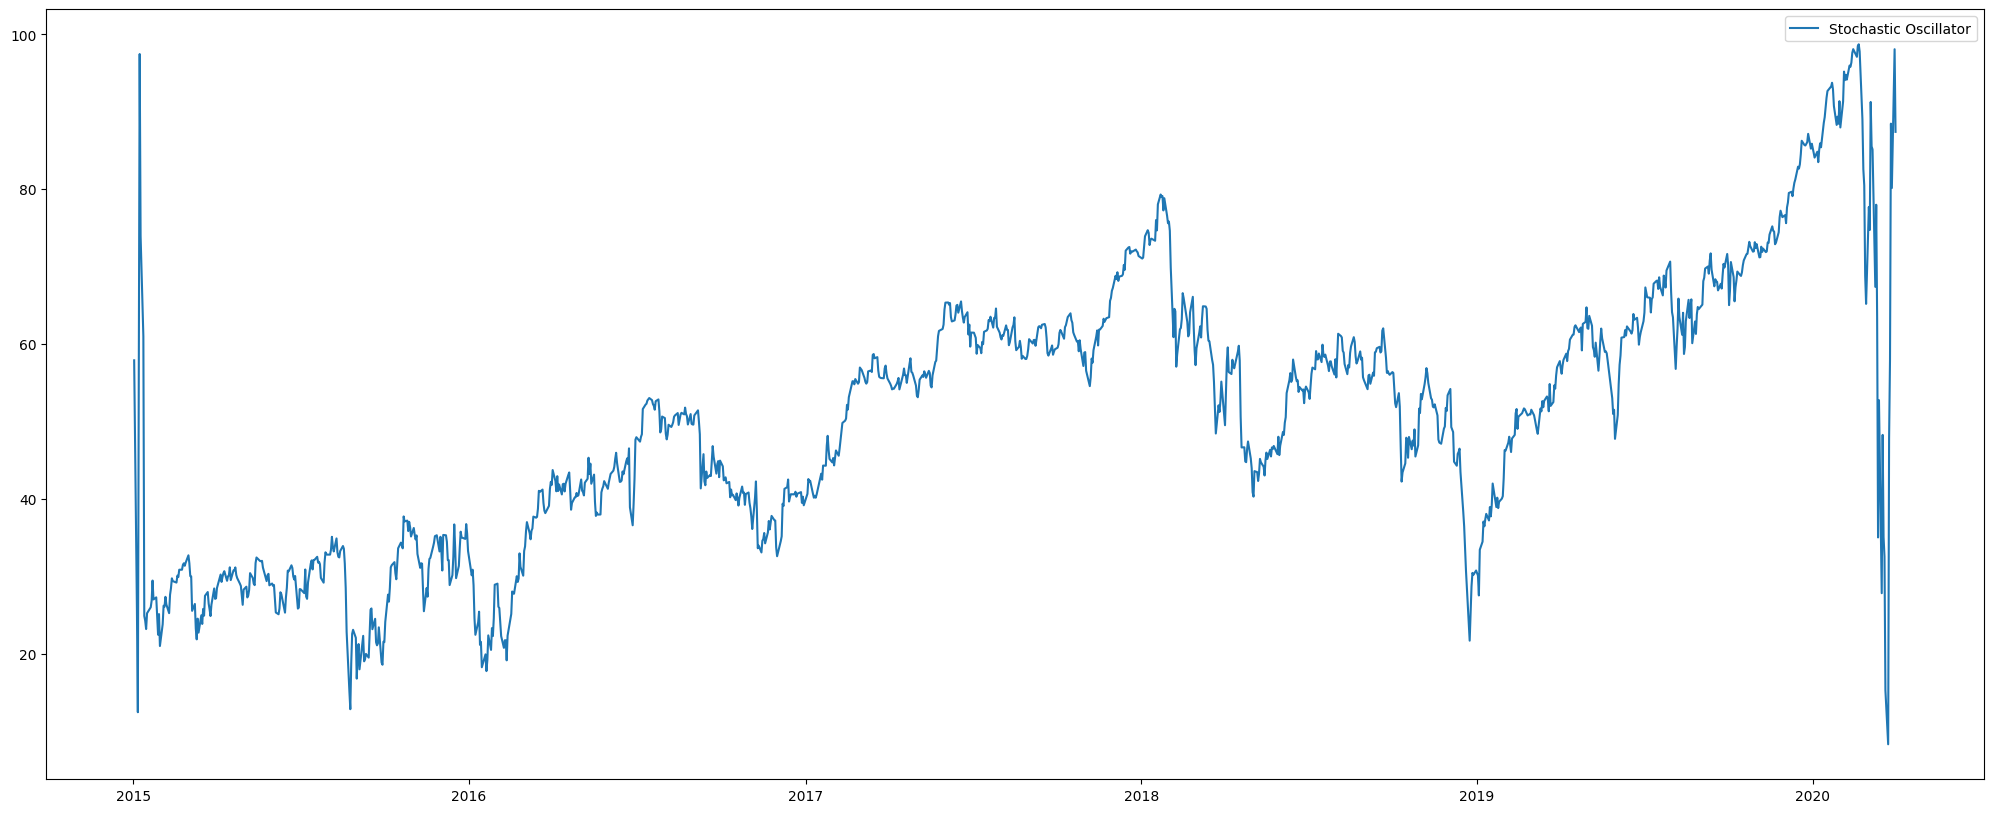

In [17]:
# Creating a figure of size 25x10
plt.figure(figsize = (25,10))

# Plotting Stochastic Oscillator vs the corresponding Date
plt.plot(dateList, kp, label = 'Stochastic Oscillator')


plt.legend()
plt.show()

Relative Strength Index - RSI

It is a momentum oscillator that measures the speed and change of price movements. The RSI oscillates between zero and 100. Traditionally the RSI is considered overbought when above 70 and oversold when below 30.

In [18]:
#converting Open column to list
open=data_frame.select('Open').rdd.flatMap(lambda x: x).collect() 

rsi=[] #list for RSI
CUavg=0
CDavg=0
x=0
for i,j in enumerate(priceL):
    if(i>=7 and i<len(priceL)-7):
        for j in range(i-6,i+8):
            # print(j)
            CDavg+=float(priceL[j])
            CUavg+=float(open[j])

        CDavg=CDavg/14
        CUavg=CUavg/14
        denom=1+(CUavg/CDavg)
        rsi.append((round((100-(100/denom)),2)))
    
    else:
     
        if (i==0):
            CDavg=(float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/7
            CUavg=(float(open[i])+float(open[i+1])+float(open[i+2])+float(open[i+3])+float(open[i+4])+float(open[i+5])+float(open[i+6]))/7
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))
        if(i==1):
            CDavg=(float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/8
            CUavg=(float(open[i-1])+float(open[i])+float(open[i+1])+float(open[i+2])+float(open[i+3])+float(open[i+4])+float(open[i+5])+float(open[i+6]))/8
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))
        if(i==2):
            CDavg=(float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/9
            CUavg=(float(open[i-2])+float(open[i-1])+float(open[i])+float(open[i+1])+float(open[i+2])+float(open[i+3])+float(open[i+4])+float(open[i+5])+float(open[i+6]))/9
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))
        if(i==3):
            CDavg=(float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/10
            CUavg=(float(priceL[i-3])+float(open[i-2])+float(open[i-1])+float(open[i])+float(open[i+1])+float(open[i+2])+float(open[i+3])+float(open[i+4])+float(open[i+5])+float(open[i+6]))/10
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))
        if(i==4):
            CDavg=(float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/11
            CUavg=(float(priceL[i-4])+float(priceL[i-3])+float(open[i-2])+float(open[i-1])+float(open[i])+float(open[i+1])+float(open[i+2])+float(open[i+3])+float(open[i+4])+float(open[i+5])+float(open[i+6]))/11
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))
            
        if(i==5):
            CDavg=(float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/12
            CUavg=(float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(open[i-2])+float(open[i-1])+float(open[i])+float(open[i+1])+float(open[i+2])+float(open[i+3])+float(open[i+4])+float(open[i+5])+float(open[i+6]))/12
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))
             
        if(i==6):
            CDavg=(float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/13
            CUavg=float(priceL[i-6])+float(priceL[i-5])+(float(priceL[i-4])+float(priceL[i-3])+float(open[i-2])+float(open[i-1])+float(open[i])+float(open[i+1])+float(open[i+2])+float(open[i+3])+float(open[i+4])+float(open[i+5])+float(open[i+6]))/13
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))
           
        if(i==len(priceL)-7):
            CDavg=(float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4])+float(priceL[i+5])+float(priceL[i+6]))/14
            CUavg=float(priceL[i-6])+float(priceL[i-5])+(float(priceL[i-4])+float(priceL[i-3])+float(open[i-2])+float(open[i-1])+float(open[i])+float(open[i+1])+float(open[i+2])+float(open[i+3])+float(open[i+4])+float(open[i+5])+float(open[i+6]))/14
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))

        if(i==len(priceL)-6):
            CDavg=(float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4]))/10
            CUavg=float(priceL[i-6])+float(priceL[i-5])+(float(priceL[i-4])+float(priceL[i-3])+float(open[i-2])+float(open[i-1])+float(open[i])+float(open[i+1])+float(open[i+2])+float(open[i+3])+float(open[i+4]))/10
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))
        if(i==len(priceL)-5):
            CDavg=(float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3])+float(priceL[i+4]))/9
            CUavg=float(priceL[i-6])+float(priceL[i-5])+(float(priceL[i-4])+float(priceL[i-3])+float(open[i-2])+float(open[i-1])+float(open[i])+float(open[i+1])+float(open[i+2])+float(open[i+3])+float(open[i+4]))/9
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))


        if(i==len(priceL)-4):
            CDavg=(float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2])+float(priceL[i+3]))/8
            CUavg=float(priceL[i-6])+float(priceL[i-5])+(float(priceL[i-4])+float(priceL[i-3])+float(open[i-2])+float(open[i-1])+float(open[i])+float(open[i+1])+float(open[i+2])+float(open[i+3]))/8
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))
            
        if(i==len(priceL)-3):
            CDavg=(float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1])+float(priceL[i+2]))/9
            CUavg=float(priceL[i-6])+float(priceL[i-5])+(float(priceL[i-4])+float(priceL[i-3])+float(open[i-2])+float(open[i-1])+float(open[i])+float(open[i+1])+float(open[i+2]))/9
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))

        if(i==len(priceL)-2):

            CDavg=(float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i])+float(priceL[i+1]))/8
            CUavg=float(priceL[i-6])+float(priceL[i-5])+(float(priceL[i-4])+float(priceL[i-3])+float(open[i-2])+float(open[i-1])+float(open[i])+float(open[i+1]))/8
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))
           
        if(i==len(priceL)-1):
            CDavg=(float(priceL[i-6])+float(priceL[i-5])+float(priceL[i-4])+float(priceL[i-3])+float(priceL[i-2])+float(priceL[i-1])+float(priceL[i]))/7
            CUavg=float(priceL[i-6])+float(priceL[i-5])+(float(priceL[i-4])+float(priceL[i-3])+float(open[i-2])+float(open[i-1])+float(open[i]))/7
            denom=1+(CUavg/CDavg)
            rsi.append((round((100-(100/denom)),2)))  

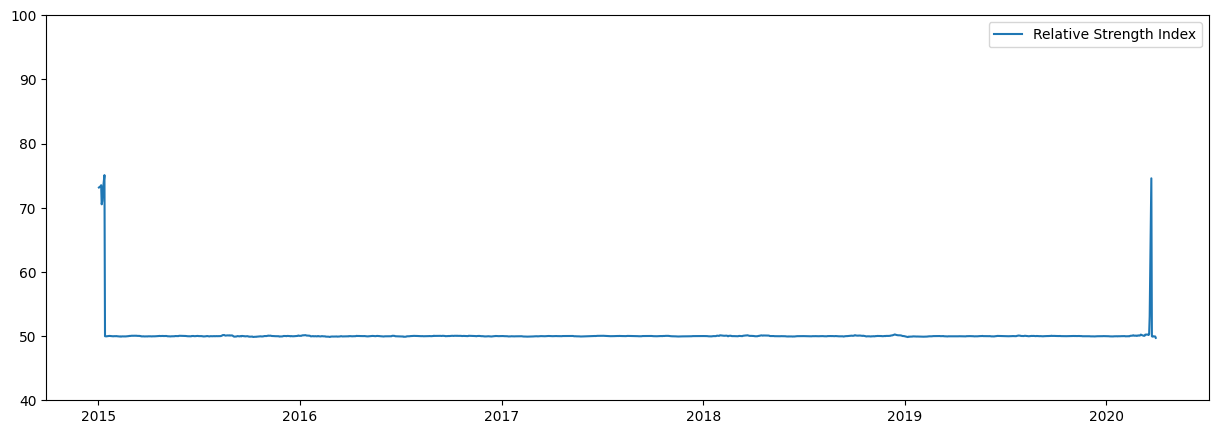

In [19]:
# Creating a figure of size 15x5
plt.figure(figsize = (15,5))
plt.ylim(40,100)

# Plotting Relative Strength Index vs the corresponding Date
plt.plot(dateList, rsi, label = 'Relative Strength Index')

plt.legend()
plt.show()

In [20]:
myList = [] # a list to append all indicators

for i in range(len(kp)):
    temp = []
    temp.append(dateList[i]) # Date in timestamp format
    temp.append(rsi[i])      # RSI for ith Date
    temp.append(SMA[i])      # SMA for ith Date
    temp.append(kp[i])       # KP for ith Date
    myList.append(temp)

In [21]:
# Column names for the dataframe
columns = ['Date','RSI','SMA' , 'K'] 

In [22]:
# Creation of dataframe
df_test = spark.createDataFrame(myList, columns) 

In [23]:
# Joining the generated data with the existing main data based on the Date

data_frame = data_frame.join(df_test, "Date", "inner")

In [24]:
# Printing the schema to verify data types

data_frame.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Price: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Chg: string (nullable = true)
 |-- Tomorrow_Close: string (nullable = true)
 |-- Today_Trend: string (nullable = false)
 |-- Tomorrow_Trend: string (nullable = false)
 |-- RSI: double (nullable = true)
 |-- SMA: double (nullable = true)
 |-- K: double (nullable = true)



In [25]:
# Display sample output table

data_frame.show(5)

+----------+------+------+------+------+-------+-------+--------------+-----------+--------------+-----+------+-----+
|      Date| Price|  Open|  High|   Low| Volume|    Chg|Tomorrow_Close|Today_Trend|Tomorrow_Trend|  RSI|   SMA|    K|
+----------+------+------+------+------+-------+-------+--------------+-----------+--------------+-----+------+-----+
|2020-03-31| 545.7| 554.2|557.82|543.75|628.15M|-0.0187|        556.11|       DOWN|            UP|49.73| 409.0|87.41|
|2020-03-30|556.11|544.04|557.98|543.28|454.73M| 0.0324|        538.64|         UP|          DOWN|49.94|416.47|98.08|
|2020-03-27|538.64|535.44|553.94|530.38|481.76M|-0.0148|        546.74|         UP|            UP|49.96|474.93|80.16|
|2020-03-26|546.74|523.51|549.11|523.07|594.86M| 0.0574|        517.05|         UP|          DOWN|49.99|479.43|88.47|
|2020-03-25|517.05|511.78| 533.4|506.02|725.00M| 0.0196|        507.13|         UP|          DOWN|49.92|483.44|58.02|
+----------+------+------+------+------+-------+-------+

In [26]:
# Casting Price data from type String to type Double

data_frame = data_frame.withColumn("Price",data_frame.Price.cast('double'))

In [27]:
# Extracting data from dataframe and converting it to list

date = data_frame.select('Date').rdd.flatMap(lambda x: x).collect() # Date list
price = data_frame.select('Price').rdd.flatMap(lambda x: x).collect() # Price list
SMA = data_frame.select('SMA').rdd.flatMap(lambda x: x).collect() # Simple Moving Average
RSI = data_frame.select('RSI').rdd.flatMap(lambda x: x).collect() # Relative Strength Index
K = data_frame.select('K').rdd.flatMap(lambda x: x).collect() # Stochastic Oscillator

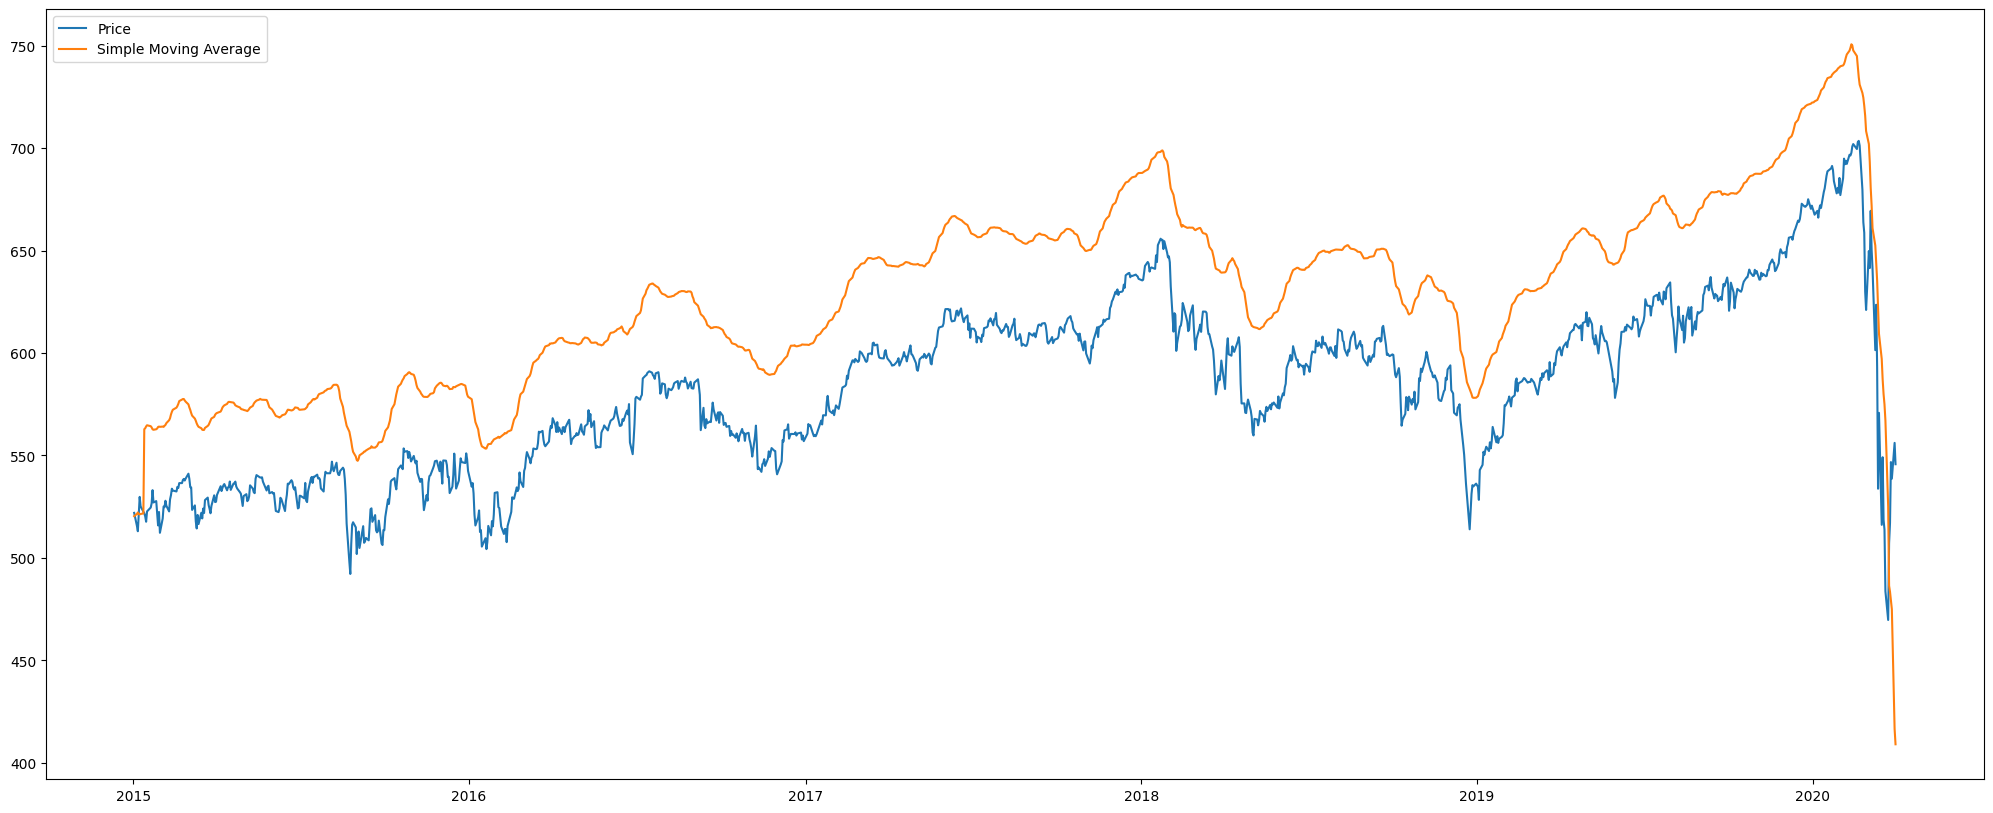

In [28]:
plt.figure(figsize = (25,10))
plt.plot(date, price, label = "Price")
plt.plot(date, SMA, label = "Simple Moving Average")
plt.legend()
plt.show()

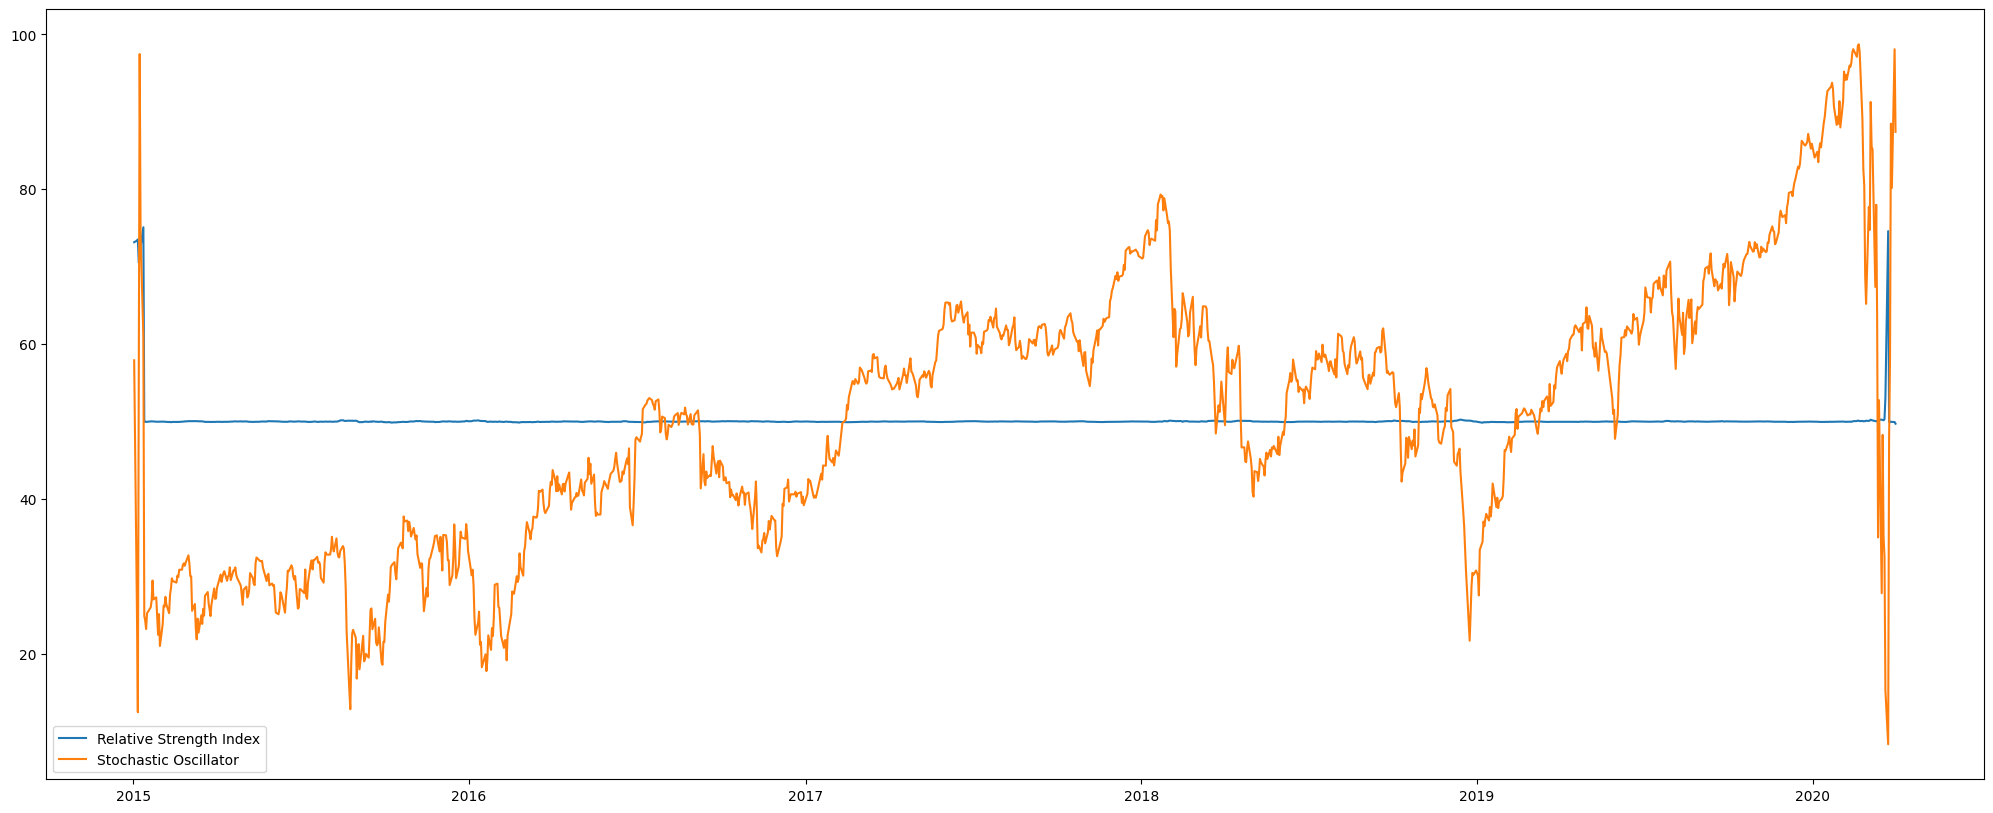

In [29]:
plt.figure(figsize = (25,10))
plt.plot(date, RSI, label = "Relative Strength Index")
plt.plot(date, K, label = "Stochastic Oscillator")
plt.legend()
plt.show()

# GDP, UNEMPLOYMENT RATE, INFLATION RATE

In [30]:
def get_date_df():
    initial_date = datetime.date(2015, 1, 1 )
    days = 1917
    one_day = datetime.timedelta(days=1)
    all_days = [{"date": initial_date + i * one_day} for i in range(days)]
    return spark.createDataFrame(Row(**x) for x in all_days)
date_df = get_date_df()

In [31]:
usa_gdp_df = gdp_df.select(['location', 'time', 'value']).where(gdp_df['location'] == "USA")

In [32]:
def myfunc(time_str):
    time_str = str(time_str)
    if "Q1" in time_str:
        return time_str.replace("Q1", "01-01")
    elif "Q2" in time_str:
        return time_str.replace("Q2", "04-01")
    elif "Q3" in time_str:
        return time_str.replace("Q3", "07-01")
    elif "Q4" in time_str:
        return time_str.replace("Q4", "10-01")
        
    return time_str

udf_myfunc = F.udf(lambda z: myfunc(z), StringType())

In [33]:
usa_gdp_df = usa_gdp_df.select(['location', 'time', 'value', udf_myfunc('time').alias('Date')])

In [34]:
usa_gdp_df = usa_gdp_df.withColumn('dateFormat', F.to_timestamp(F.col('Date'), 'yyyy-MM-dd')) \
                        .drop('Date', 'time', 'location') \
                        .withColumnRenamed('dateFormat', 'date')


In [35]:
usa_gdp_df = date_df.join(usa_gdp_df, "date", "left")

In [36]:
usa_gdp_df = usa_gdp_df.withColumn("value", F.last('value', True).over(Window.orderBy('date').rowsBetween(-sys.maxsize, 0)))
usa_gdp_df = usa_gdp_df.withColumnRenamed("value", "GDP Val")

In [37]:
usa_unemp_df = unemp_df.select(['time', 'value']).where(unemp_df['location'] == "USA")

In [38]:
usa_unemp_df = usa_unemp_df.withColumnRenamed('time', 'Date')

In [39]:
usa_unemp_df = date_df.join(usa_unemp_df, "date", "left")

In [40]:
usa_unemp_df = usa_unemp_df.withColumn("value", F.last('value', True).over(Window.orderBy('date').rowsBetween(-sys.maxsize, 0)))
usa_unemp_df = usa_unemp_df.withColumnRenamed("value", "UnEmp Val")

In [41]:
usa_inf_df = inflation_df.withColumn('dateFormat', F.to_timestamp(F.col('Date'), 'yyyy-MM-dd')) \
                        .drop('Date') \
                        .withColumnRenamed('dateFormat', 'Date')

In [42]:
usa_inf_df = date_df.join(usa_inf_df, "date", "left")

In [43]:
usa_inf_df = usa_inf_df.withColumn("value", F.last('value', True).over(Window.orderBy('date').rowsBetween(-sys.maxsize, 0)))
usa_inf_df = usa_inf_df.withColumnRenamed("value", "Inflation Rate")

In [44]:
data_frame = data_frame.join(usa_unemp_df, "Date", "inner")
data_frame = data_frame.join(usa_gdp_df, "Date", "inner")
data_frame = data_frame.join(usa_inf_df, "Date", "inner")

In [45]:
data_frame.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Price: double (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Chg: string (nullable = true)
 |-- Tomorrow_Close: string (nullable = true)
 |-- Today_Trend: string (nullable = false)
 |-- Tomorrow_Trend: string (nullable = false)
 |-- RSI: double (nullable = true)
 |-- SMA: double (nullable = true)
 |-- K: double (nullable = true)
 |-- UnEmp Val: double (nullable = true)
 |-- GDP Val: double (nullable = true)
 |-- Inflation Rate: double (nullable = true)



In [46]:
data_frame.show(1,truncate = False)

+----------+-----+-----+------+------+-------+-------+--------------+-----------+--------------+-----+-----+-----+---------+-------------+--------------+
|Date      |Price|Open |High  |Low   |Volume |Chg    |Tomorrow_Close|Today_Trend|Tomorrow_Trend|RSI  |SMA  |K    |UnEmp Val|GDP Val      |Inflation Rate|
+----------+-----+-----+------+------+-------+-------+--------------+-----------+--------------+-----+-----+-----+---------+-------------+--------------+
|2020-03-31|545.7|554.2|557.82|543.75|628.15M|-0.0187|556.11        |DOWN       |UP            |49.73|409.0|87.41|4.4      |109.198128767|1.5           |
+----------+-----+-----+------+------+-------+-------+--------------+-----------+--------------+-----+-----+-----+---------+-------------+--------------+
only showing top 1 row



In [47]:
# Loading preFinal data into data_frame as spark dataframe

data_frame_fin = spark.read.format('csv').option('header','true').load(fin_data_path)

In [48]:
data_frame_fin.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Chg: string (nullable = true)
 |-- GR: string (nullable = true)
 |-- Sentiment Score: string (nullable = true)



In [49]:
data_frame_fin = data_frame_fin.withColumn("newDate", F.to_date(F.col("date"), "yyyy-MM-dd")) \
    .drop('date').withColumnRenamed("newDate", "Date")

In [50]:
mergecols = ['Price', 'Open', 'High', 'Low', 'Volume', 'Chg', 'Date']
data_frame_fin = data_frame_fin.join(data_frame, mergecols, "inner")

In [51]:
data_frame_fin.printSchema()

root
 |-- Price: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Chg: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- GR: string (nullable = true)
 |-- Sentiment Score: string (nullable = true)
 |-- Tomorrow_Close: string (nullable = true)
 |-- Today_Trend: string (nullable = false)
 |-- Tomorrow_Trend: string (nullable = false)
 |-- RSI: double (nullable = true)
 |-- SMA: double (nullable = true)
 |-- K: double (nullable = true)
 |-- UnEmp Val: double (nullable = true)
 |-- GDP Val: double (nullable = true)
 |-- Inflation Rate: double (nullable = true)



In [52]:
# data_frame_fin.coalesce(1).write.mode('overwrite').option('header', True).csv("final_data.csv")